<a href="https://colab.research.google.com/github/Ashrafalaghbari/oil-production-forecasting/blob/main/optimal_TCN_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Dropout
from keras.layers import LSTM
from tcn import TCN
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [ ]:
!nvidia-smi

In [ ]:
# # check if GPU is utilized 
# device_name = tf.config.experimental.list_physical_devices()[-1][-1]
# if device_name != 'GPU':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

In [ ]:
# Select the best features
def select_features(df, target, correlation_type, threshold):
    if (threshold < -1 ) | (threshold > 1 ) :
            raise SystemError('correlation threshold is out of bounds')
    features = df.corr(correlation_type).loc[target].drop(target)
    best_features = features.where(abs(features) > threshold).dropna()
    df = pd.concat([df[target], df[best_features.index]], axis=1)
    return df

# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to new feature range[0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [ ]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #Symmetric (adjusted) MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2 * result/ len(actual) 
    return result * 100

In [ ]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")

In [ ]:
# select feature based on correlation
series = select_features(series, "BORE_OIL_VOL", "spearman", 0)
# select features manually
series =series[["ON_STREAM_HRS",'BORE_GAS_VOL', 'BORE_WAT_VOL',
                'AVG_CHOKE_SIZE_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                 "BORE_OIL_VOL"]] 

In [ ]:
series["next_choke_size"] = series['AVG_CHOKE_SIZE_P'].shift(-1)
series["next_on_stream"] = series['ON_STREAM_HRS'].shift(-1)
series["next_BORE_GAS_VOL"] = series['BORE_GAS_VOL'].shift(-1)
series.dropna(inplace=True)

In [ ]:
column_to_move = series.pop("BORE_OIL_VOL")

# insert column with insert(location, column_name, column_value)

series.insert(len(series.columns), "BORE_OIL_VOL", column_to_move)

In [ ]:
# # Data visulaization and disribution plots for well F-14 after including the injectors
data = series.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 28))

axs = axs.ravel()

for id, column in enumerate(data):

    axs[id].plot(series[column])
    axs[id].grid(True)
    axs[id].legend([column], loc='lower left', fontsize=9, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
# # # convert series to stationary 
series_diff = series.copy()
diff_order = 1
series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)
# # convert the stationary series to supervise learning
timesteps = 1 # lag features
steps_ahead = 1
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

In [ ]:
series_supervised

In [ ]:
series_supervised.drop(['ON_STREAM_HRS(t)', 'BORE_GAS_VOL(t)',
       'BORE_WAT_VOL(t)', 'AVG_CHOKE_SIZE_P(t)', 
       'next_choke_size(t)', 'next_on_stream(t)',
        'next_BORE_GAS_VOL(t)', 
       'F_4_BORE_WI_VOL(t)',
       'F_5_BORE_WI_VOL(t)'
       ], axis=1, inplace= True)

In [ ]:
# # split into train and test sets
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(1524, 11) (381, 11)


In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(1524, 11) (381, 11)


In [ ]:
# # reshape input to be 3D [samples, timesteps, features]
n_features = len(series.columns) 

train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1524, 1, 10) (1524, 1) (381, 1, 10) (381, 1)


In [ ]:
# Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
from keras.layers import Conv1D

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

# fit the model
neurons= 22

model = Sequential()
model.add(Conv1D(filters = 46, kernel_size=3, dilation_rate=1, padding='causal',
                 input_shape=(timesteps, n_features)))
model.add(Conv1D(filters =46, kernel_size=1, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 46, kernel_size=2, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 125, kernel_size=12, dilation_rate=1, padding='causal'))


model.add(LSTM(neurons, activation="tanh",
               input_shape=(timesteps, n_features)))



model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=2, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

Epoch 1/700
762/762 - 6s - loss: 0.0263 - val_loss: 4.0579e-04 - 6s/epoch - 8ms/step
Epoch 2/700
762/762 - 3s - loss: 0.0024 - val_loss: 3.3447e-04 - 3s/epoch - 3ms/step
Epoch 3/700
762/762 - 3s - loss: 0.0015 - val_loss: 1.9879e-04 - 3s/epoch - 3ms/step
Epoch 4/700
762/762 - 3s - loss: 0.0011 - val_loss: 1.6823e-04 - 3s/epoch - 3ms/step
Epoch 5/700
762/762 - 3s - loss: 9.0254e-04 - val_loss: 1.6317e-04 - 3s/epoch - 3ms/step
Epoch 6/700
762/762 - 3s - loss: 7.6761e-04 - val_loss: 1.5183e-04 - 3s/epoch - 3ms/step
Epoch 7/700
762/762 - 3s - loss: 6.6836e-04 - val_loss: 1.3457e-04 - 3s/epoch - 3ms/step
Epoch 8/700
762/762 - 3s - loss: 5.9526e-04 - val_loss: 1.1916e-04 - 3s/epoch - 3ms/step
Epoch 9/700
762/762 - 3s - loss: 5.4108e-04 - val_loss: 1.0781e-04 - 3s/epoch - 4ms/step
Epoch 10/700
762/762 - 3s - loss: 4.9636e-04 - val_loss: 9.9511e-05 - 3s/epoch - 4ms/step
Epoch 11/700
762/762 - 3s - loss: 4.5645e-04 - val_loss: 9.3483e-05 - 3s/epoch - 4ms/step
Epoch 12/700
762/762 - 3s - loss: 4

KeyboardInterrupt: ignored

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

# fit the model
neurons= 22

model = Sequential()
model.add(Conv1D(filters = 46, kernel_size=3, dilation_rate=1, padding='causal',
                 input_shape=(timesteps, n_features)))
model.add(Conv1D(filters =46, kernel_size=1, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 46, kernel_size=2, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 125, kernel_size=12, dilation_rate=1, padding='causal'))


model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=2, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

Epoch 1/700
762/762 - 5s - loss: 0.0146 - val_loss: 3.9217e-04 - 5s/epoch - 7ms/step
Epoch 2/700
762/762 - 2s - loss: 0.0015 - val_loss: 1.7227e-04 - 2s/epoch - 3ms/step
Epoch 3/700
762/762 - 2s - loss: 9.0010e-04 - val_loss: 1.1180e-04 - 2s/epoch - 3ms/step
Epoch 4/700
762/762 - 2s - loss: 6.1101e-04 - val_loss: 8.6051e-05 - 2s/epoch - 3ms/step
Epoch 5/700
762/762 - 2s - loss: 4.8728e-04 - val_loss: 6.9632e-05 - 2s/epoch - 3ms/step
Epoch 6/700
762/762 - 2s - loss: 4.3528e-04 - val_loss: 6.1371e-05 - 2s/epoch - 3ms/step
Epoch 7/700
762/762 - 2s - loss: 4.0019e-04 - val_loss: 5.7662e-05 - 2s/epoch - 3ms/step
Epoch 8/700
762/762 - 2s - loss: 3.6855e-04 - val_loss: 5.5727e-05 - 2s/epoch - 3ms/step
Epoch 9/700
762/762 - 2s - loss: 3.4005e-04 - val_loss: 5.4363e-05 - 2s/epoch - 3ms/step
Epoch 10/700
762/762 - 2s - loss: 3.1508e-04 - val_loss: 5.3047e-05 - 2s/epoch - 3ms/step
Epoch 11/700
762/762 - 2s - loss: 2.9352e-04 - val_loss: 5.1593e-05 - 2s/epoch - 3ms/step
Epoch 12/700
762/762 - 2s -

In [ ]:
#  best tcn architecture is the one used in the papaer

In [ ]:
# load the trained saved model
model_saved = tf.keras.models.load_model('/content/drive/MyDrive/my_trained_models/optimal_lstm_model_200Eps.h5')

In [ ]:
# Load the best weights
model_saved.load_weights('/content/drive/MyDrive/my_trained_models/optimal_lstm_wts.hdf5')

In [ ]:
# Load the best weights
model.load_weights(os.path.join(directory, 'mdl_wts.hdf5'))

In [ ]:
model_saved.evaluate(test_X, test_y, verbose=0)

1.4128404473012779e-05

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)
best_epoch = loss_tracking.index(score) + 1
# validation loss and corresponding epoch for the saved model
print(f'Epoch:{best_epoch}\nValidation loss: {score}') 

Epoch:700
Validation loss: 1.1491964869492222e-05


In [ ]:
# # continue if training is interrupted 
# model.compile(loss='mean_squared_error',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
# early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
#                                 restore_best_weights=True, mode='min')
# # save the best weights if training is interrupted
# mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
#                             save_best_only=True,
#                             monitor='val_loss', mode='min') 
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# # Set the initial and total number of epochs
# initial_epoch = 1
# n_epochs = 2000

# # Run the training loop
# for epoch in range(initial_epoch , n_epochs+1):
#     print(f'Epoch {epoch}/{n_epochs}')
#     # Train the model for one epoch
#     history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save, reduce_lr_loss],
#                     epochs=1, batch_size=2, validation_data=(test_X, test_y),
#                      verbose=2,
#                      shuffle=False)
#     # to find for which epoch each loss belongs
#     validation_loss= model.evaluate(test_X, test_y, verbose=0)
#     loss_tracking.append(validation_loss)
#     # Save the model every 10 epochs
#     if epoch % 50 == 0:
#         # Save the model  in HDF5 foramt with a filename that includes the epoch number
#         #model.save(f'model_{epoch}Eps.h5')
#         model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

NameError: ignored

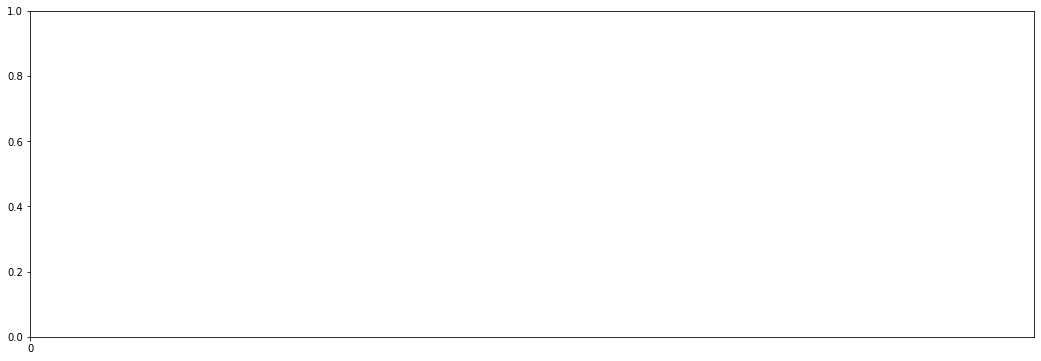

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot(loss_tracking, label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [ ]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:], verbose=1)


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat.ravel()) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values.ravel() 
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values.ravel()

12/12 [==============================] - 0s 2ms/step


In [ ]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1,0]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

In [ ]:
series.iloc[-len(test)-steps_ahead:,-1]

DATEPRD
2014-03-11    3333.536720
2014-03-12    3312.214262
2014-03-13    3421.594068
2014-03-14    3415.241360
2014-03-15    3419.141042
                 ...     
2015-03-18    1659.440731
2015-03-19    1662.711432
2015-03-20    1707.494884
2015-03-21    1725.420844
2015-03-22    1620.632599
Name: BORE_OIL_VOL, Length: 377, dtype: float64

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

current_timestep = 1
# actual value of oil rate at current time step
# steps_ahead = 4
#drop all the variables that we don't want to predict
vars_y = originalSeries_supervised.columns[-steps_ahead*len(series.columns):]
vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
originalSeries_supervised.drop(columns=vars_to_drop, inplace=True)
originalSeries_xt = originalSeries_supervised.iloc[-len(test):,-steps_ahead-2]


# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
#inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)
inv_yhat_cum = inv_scale_yhat

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].ravel()[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
#col = pd.DataFrame.from_records(col) # creates a DataFrame from a list of records
col = pd.DataFrame(col)
#col.columns = pd.RangeIndex(start=1, stop=steps_ahead+1, step=1)
inv_yhat = col.values.ravel() # convert df to NumpyArray

NameError: ignored

In [ ]:
inv_yhat = np.add(inv_scale_yhat,agg)

In [ ]:
inv_y[np.where(inv_y <0)]

array([-1.81898940e-12, -3.83693077e-13, -1.81898940e-12, -1.81898940e-12,
       -1.81898940e-12, -1.81898940e-12])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-229.85074056, -201.1940488 , -129.91894531, -129.54980469,
       -129.54980469, -129.54980469])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-163.72281087,  -25.71943942,  -20.23535156,  -19.48730469,
        -19.48730469,  -19.48730469])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-193.72964681,  -66.68428317,  -19.41894531,  -18.77441406,
        -18.77441406,  -18.77441406])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-255.16617025, -167.07588473,  -37.01660156,  -41.84667969,
        -41.84667969,  -41.84667969])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-193.81265462,  -66.7252988 ,  -19.41699219,  -18.77148438,
        -18.77148438,  -18.77148438])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-370.86734212, -266.39229098, -111.45996094,  -61.03417969,
        -61.15429688,  -61.15429688])

In [ ]:
inv_yhat[np.where(inv_y <0)]

array([-184.43960775, -117.37275973,   31.31445312,   32.32421875,
         32.32421875,   32.32421875])

In [ ]:
r2_score(inv_y,inv_yhat)

0.9825556356039782

In [ ]:
r2_score(inv_y,inv_yhat)

0.943113222152864

In [ ]:
r2_score(inv_y,inv_yhat)

0.9678677413182221

In [ ]:
r2_score(inv_y,inv_yhat)

0.9785535819551673

In [ ]:
MAPE(inv_y[np.where(~(inv_y <0))],inv_yhat[np.where(~(inv_y <0))])

10.554805617459637

In [ ]:
wMAPE(inv_y,inv_yhat)

2.2230121923686776

In [ ]:
wMAPE(inv_y,inv_yhat)

4.075756149494592

In [ ]:
inv_y.shape, inv_yhat.shape

((6,), (6,))

In [ ]:
# Performance evaluation

rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
RMSPE_test = RMSPE(inv_y, inv_yhat)
print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.5f' % MAE_test)
MAPE_test = MAPE(inv_y, inv_yhat)
print('Test MAPE: %.5f' % MAPE_test)
r2 = r2_score(inv_y, inv_yhat)
print('Test r2: %.5f' % r2)
wMAPE_test = wMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % wMAPE_test)
SMAPE_test = SMAPE(inv_y, inv_yhat)
print('Test SMAPE: %.5f ' % SMAPE_test)

Test RMSE: 97.92466
Test RMSPE: 2858157198299995.50000
Test MAE: 50.85937
Test MAPE: 245619343228612.25000
Test r2: 0.98256
Test wMAPE: 2.22301 
Test SMAPE: 7.10244 


In [ ]:
Test RMSE: 108.57802
Test RMSPE: 1050251866795420.12500
Test MAE: 59.25265
Test MAPE: 84532810027035.62500
Test r2: 0.97855
Test wMAPE: 2.58987 
Test SMAPE: 7.66815

In [ ]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

IndexError: ignored

In [ ]:
Test RMSE: 555.56135
Test MAE: 277.11301
Test r2: 0.39641
Test wMAPE: 12.32902 
Test SMAPE: 17.45901

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
inv_yhat

In [ ]:
inv_yhat[-1]

In [ ]:
plt.plot(inv_yhat[-1], label = "predicted")
plt.plot(inv_y[-1], label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y.flatten(), "prediction":inv_yhat.flatten()})
act_pred.head(5)

In [ ]:
series_to_supervised(series, series.columns, n_in=2, n_out=steps_ahead, dropnan=True).iloc[-len(test):-len(test)+5]

In [ ]:
r2_score(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
wMAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
MAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])